In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
pd.set_option('display.max_columns', None)

In [2]:
def parse_results(filename:str, mv:bool = False) -> pd.DataFrame:
    "Parse results text filename and creates a pandas DataFrame"
    
    data = defaultdict(list)
    with open(filename) as file:
        for line in file:
            if line == '\n':
                continue
            if line[:3] == 'mse':
                result = line.replace(" ", "").split(',')
                data['MSE'].append(round(float(result[0].split(':')[1]),8))
                data['MAE'].append(round(float(result[1].split(':')[1]),8))
                if not mv:
                    data['RMSE'].append(round(float(result[2].split(':')[1]),8))
                    data['MAPE'].append(round(float(result[3].split(':')[1]),8))
                    data['MSPE'].append(round(float(result[4].split(':')[1]),8))
                    data['RSE'].append(round(float(result[5].split(':')[1]),8))
                    data['R2'].append(round(float(result[6].split(':')[1]),8))
                    data['train_time'].append(round(float(result[7].split(':')[1]),8))
                    data['test_time'].append(round(float(result[8].split(':')[1]),8))
                    if len(result) > 9:
                        data['epochs'].append(round(float(result[9].split(':')[1]),8))
                    else:
                        data['epochs'].append(1)
                    
            else:
                attributes = line.split(sep='_')
#                 print(attributes)
                data['model'].append(attributes[0])
                data['lookback'].append(int(attributes[1].split('-')[1]))
                data['future'].append(int(attributes[3].split('-')[1]))
                data['pos'].append(attributes[5].split('-')[1])
                data['val'].append(attributes[6].split('-')[1])
                data['temp'].append(attributes[7].split('-')[1].split(' ')[0])

    return pd.DataFrame.from_dict(data)

def parse_lstms(filename:str) -> pd.DataFrame:
    "Parse results text filename and creates a pandas DataFrame"
    
    data = defaultdict(list)
    with open(filename) as file:
        for line in file:
            if line == '\n':
                continue
            if line[:3] == 'mse':
                result = line.replace(" ", "").split(',')
                data['MSE'].append(round(float(result[0].split(':')[1]),8))
                data['MAE'].append(round(float(result[1].split(':')[1]),8))
                data['RMSE'].append(round(float(result[2].split(':')[1]),8))
                data['MAPE'].append(round(float(result[3].split(':')[1]),8))
                data['R2'].append(round(float(result[4].split(':')[1]),8))
            else:
                attributes = line.split(sep='_')
                model = attributes[0]
                data['lookback'].append(int(attributes[2].split('-')[1]))
                data['future'].append(int(attributes[3].split('-')[1]))

    return pd.DataFrame.from_dict(data)

def slice_and_dice(formers:pd.DataFrame, lstms: pd.DataFrame) -> pd.DataFrame:
    """."""
    transformer, autoformer, informer = \
    formers[formers['model'] == 'Transformer'].drop('model', axis = 1), \
    formers[formers['model'] == 'Autoformer'].drop('model', axis = 1), \
    formers[formers['model'] == 'Informer'].drop('model', axis = 1),
    df = autoformer.merge(informer, how = "left", on=["lookback", "future", "pos", "val", "temp"], \
                              suffixes=('-Autoformer', '-Informer'))\
                       .merge(transformer, how = "left", on=["lookback", "future", "pos", "val", "temp"], \
                             suffixes=('_ello', '-Transformer'))\
                       .merge(lstms, how="left",  on=["lookback", "future"], suffixes=('-Transformer', '-LSTM'))

    return df

# def compare_uni_multi(uni: pd.DataFrame, mv: pd.DataFrame) -> pd.DataFrame:
    

In [6]:
## Univariate ##
univariate_formers_org = parse_results('formers-original-data.txt').\
                drop_duplicates(subset=['model', 'lookback', 'future', 'pos','val','temp'], keep = 'last')
univariate_formers_org['time_per_epoch'] = univariate_formers_org['train_time']/univariate_formers_org['epochs']
univariate_lstms_org = parse_lstms('new_results_lstm.txt')

## multivariate ##
multivariate_formers_org = parse_results('formers-multivariate-result.txt', True).\
                drop_duplicates(subset=['model', 'lookback', 'future', 'pos','val','temp'],keep = 'last')
multivariate_lstms_org = parse_lstms('result-lstm-multivariate.txt')
# lstms_red = parse_lstms('result-lstm-reduced-data.txt')

In [7]:
# univariate_formers_org[(univariate_formers_org['lookback'] == 24) & (univariate_formers_org['future'] == 1)]
# univariate_formers_org.tail(10)
# multivariate_formers_org.head()
# multivariate_lstms_org.head()

In [22]:
# df_org = slice_and_dice(univariate_formers_org, univariate_lstms_org)
df_org = slice_and_dice(multivariate_formers_org, multivariate_lstms_org)
df_org['lookback'].unique()
# df_org['data_type'] = 'original'

array([  6,  48,  96, 168, 336], dtype=int64)

## MultiVariate - UniVariate ##

In [23]:
df_uni_mv = univariate_formers_org[["model","lookback", "future", "pos", "val", "temp", "MSE", "MAE"]].merge(multivariate_formers_org, how = "left", on=["model","lookback", "future", "pos", "val", "temp"], \
                              suffixes=('-Uni', '-multi'))
df_uni_mv = df_uni_mv.dropna()
# df_uni_mv['multi_better'] = np.where(df_uni_mv['MAE-Uni'] > df_uni_mv['MAE-multi'], 1,0)

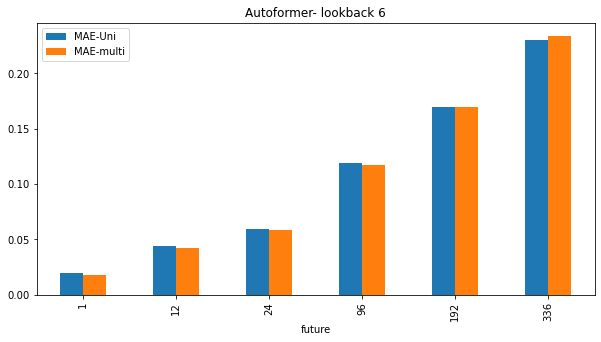

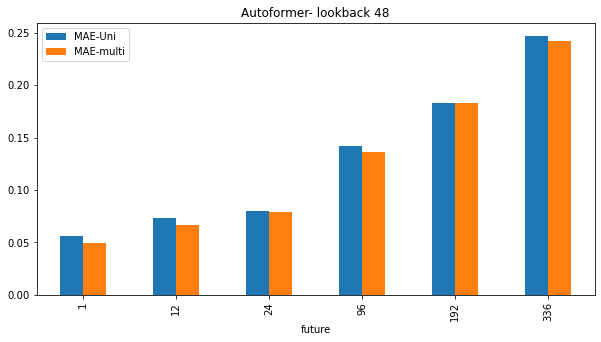

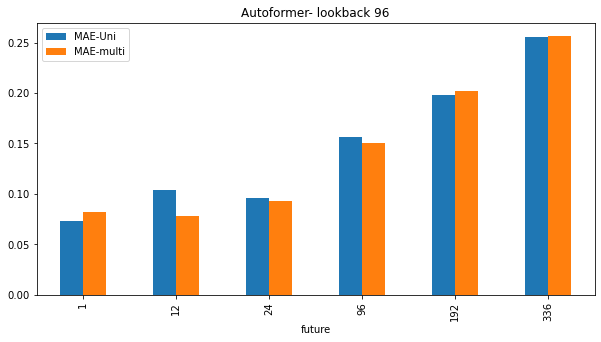

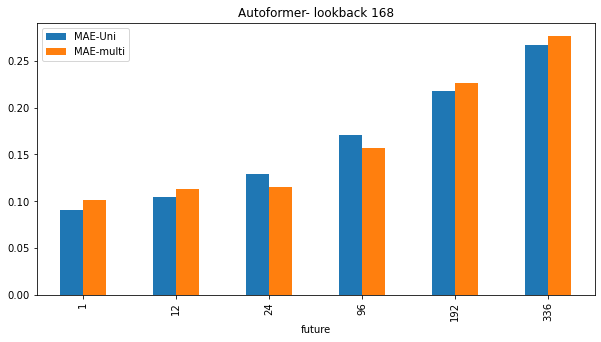

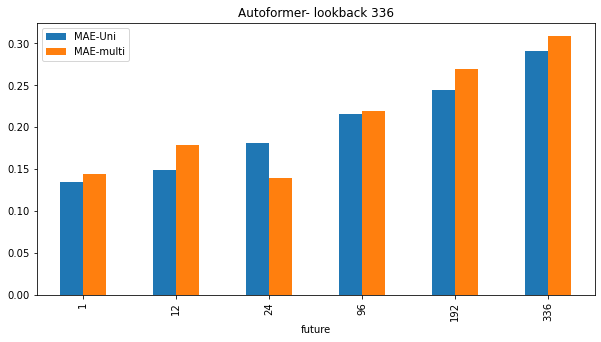

In [27]:
model = 'Autoformer'
# lookback = 6
if model == 'Transformer':
    pos, val, temp = 'True', 'False', 'False'
elif model == 'Informer':
    pos, val, temp = 'True', 'True', 'True'
elif model == 'Autoformer':
    pos, val, temp = 'False', 'True', 'True'
    
for lookback in [6, 48, 96, 168, 336]:    
    result_df = df_uni_mv[(df_uni_mv['model'] == model)\
              & (df_uni_mv['lookback'] == lookback)\
              & (df_uni_mv['pos'] == pos)\
              & (df_uni_mv['val'] == val)\
              & (df_uni_mv['temp'] == temp)]
    # result_df[['MAE-Uni','MAE-multi']] *= 10
    ax = result_df.plot.bar(x='future', y=['MAE-Uni','MAE-multi'],figsize=(10,5))
    ax.set_title(model + "- lookback "+ str(lookback) )

## time comparison ##

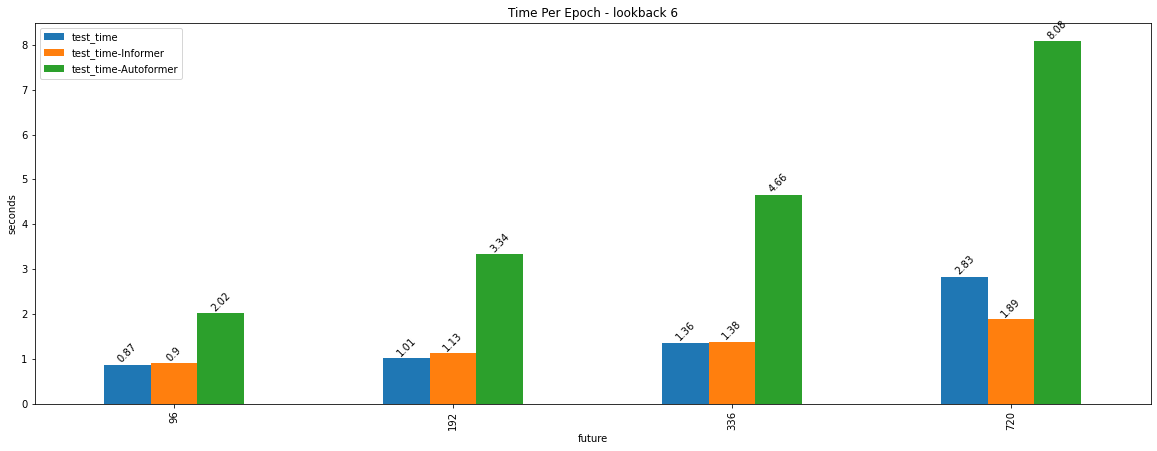

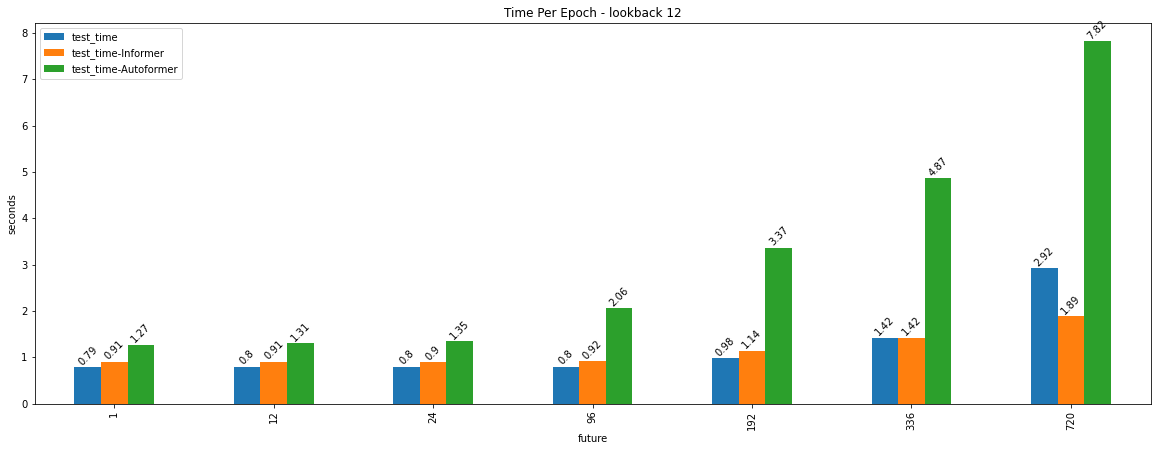

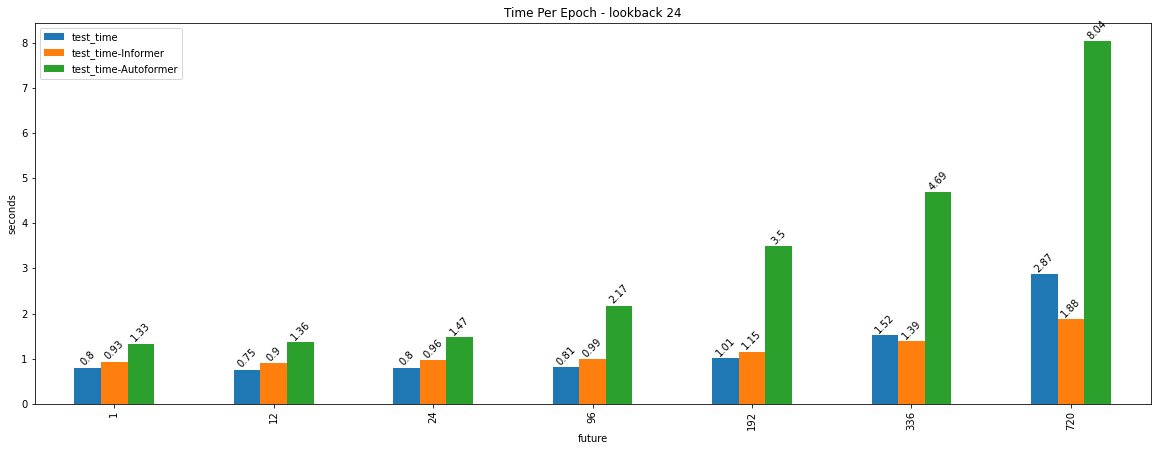

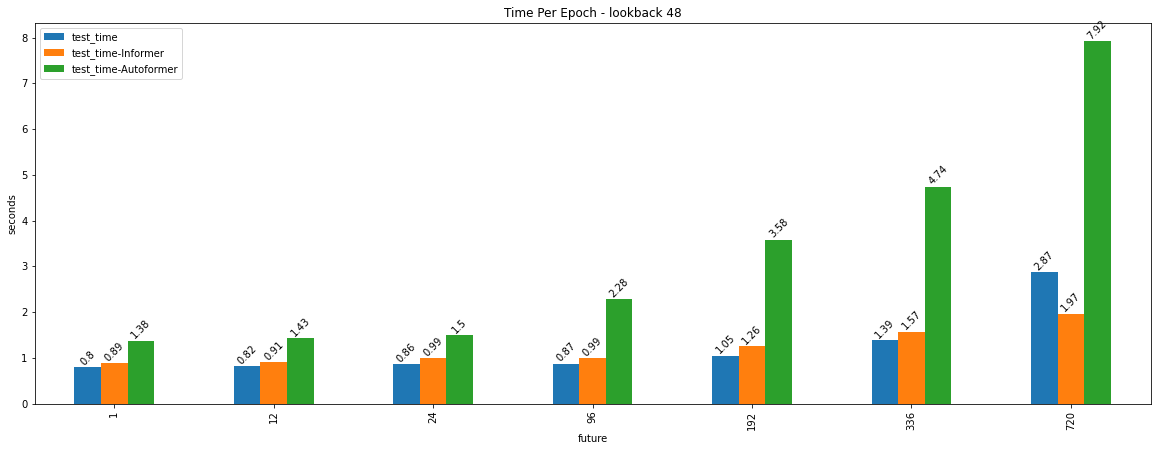

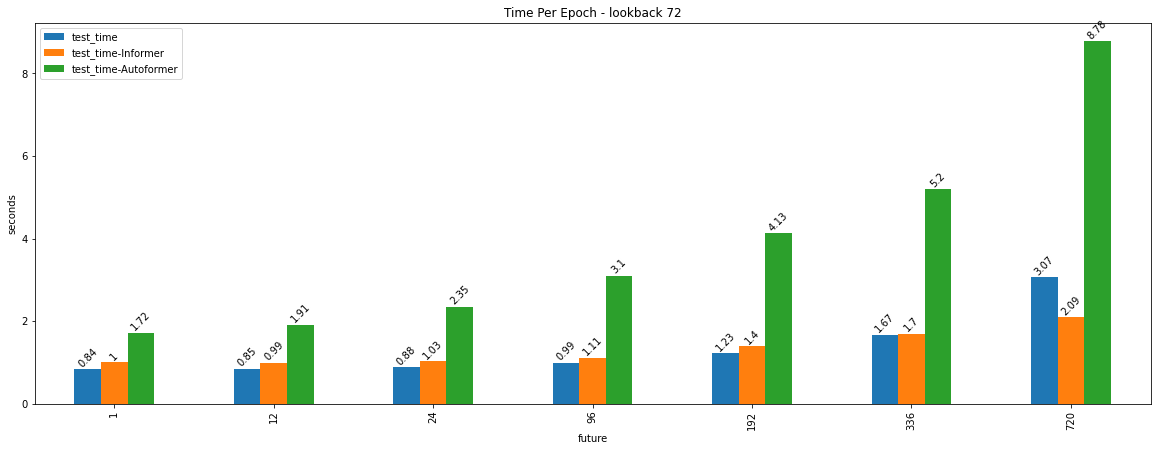

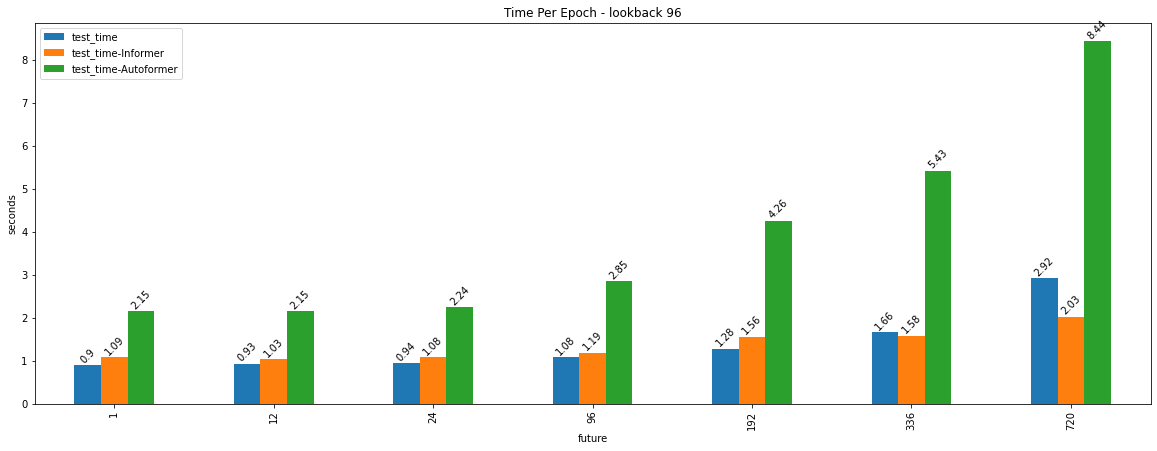

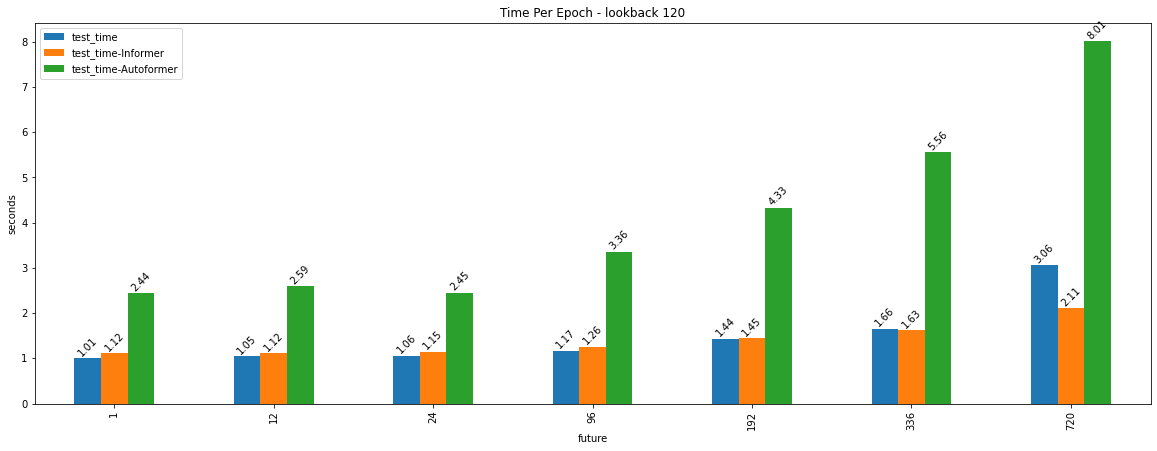

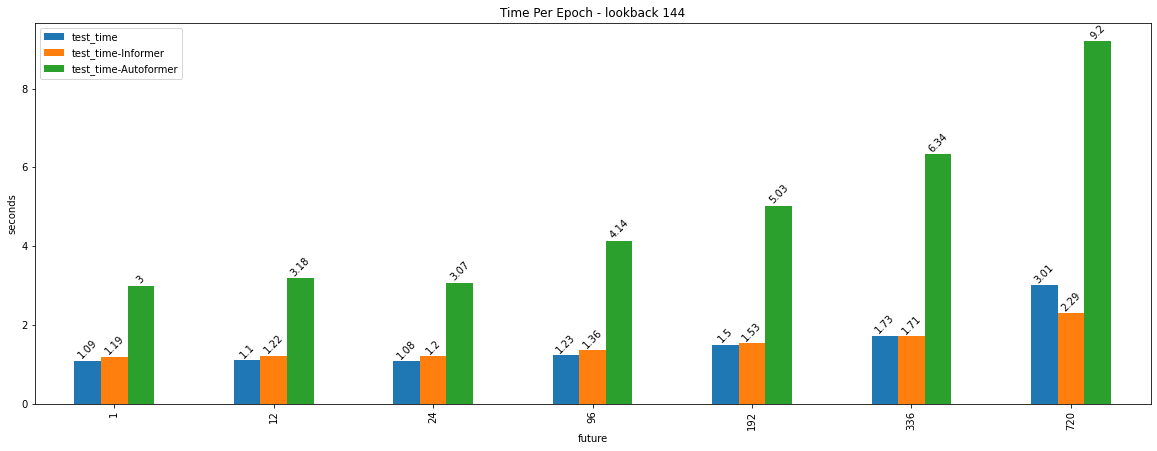

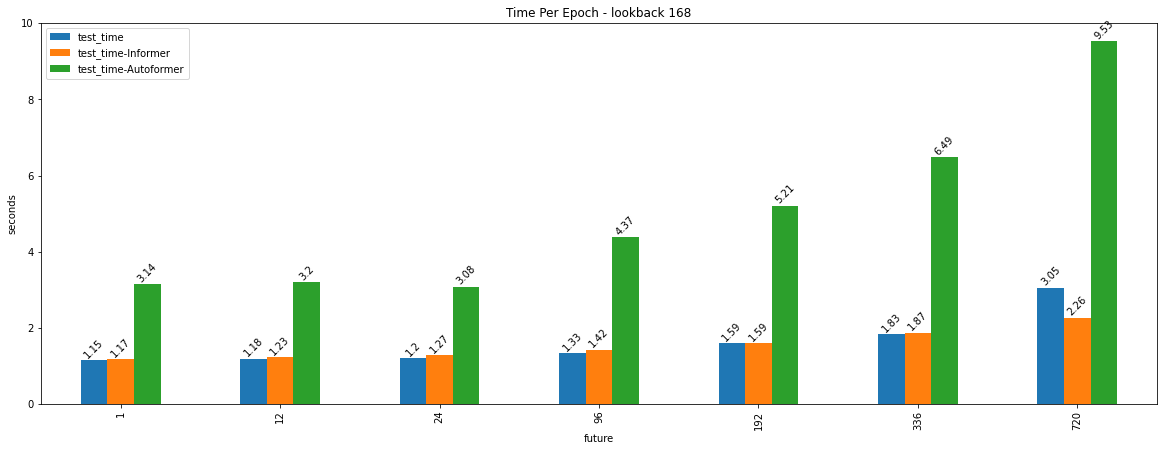

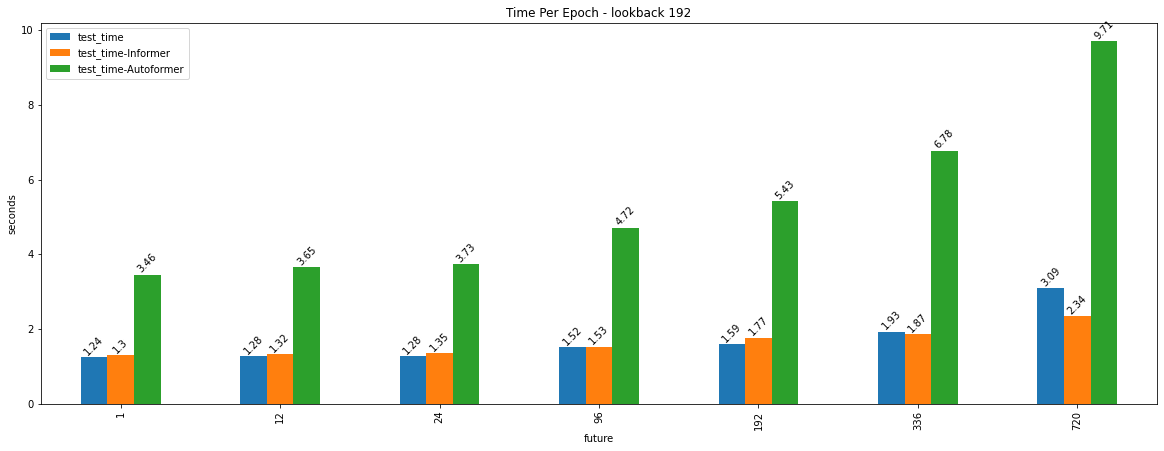

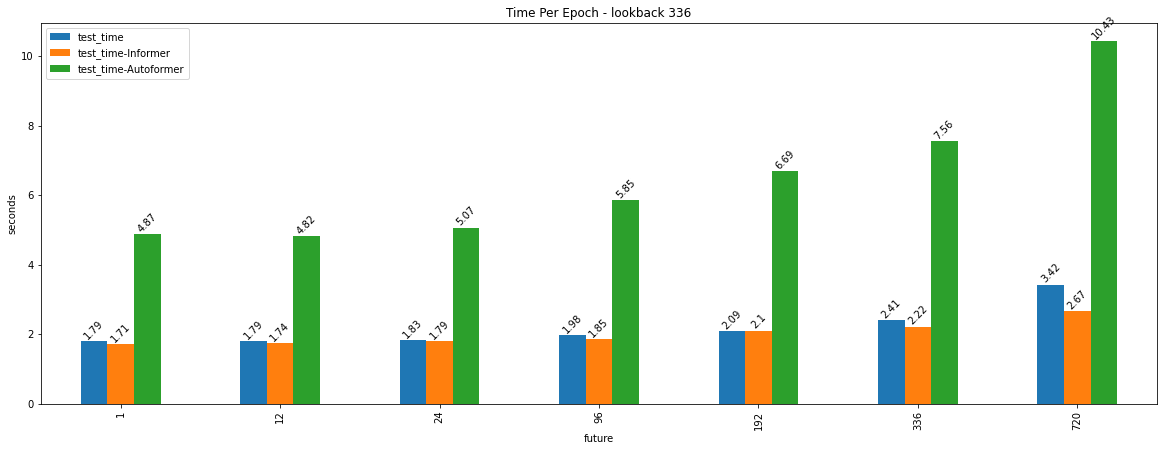

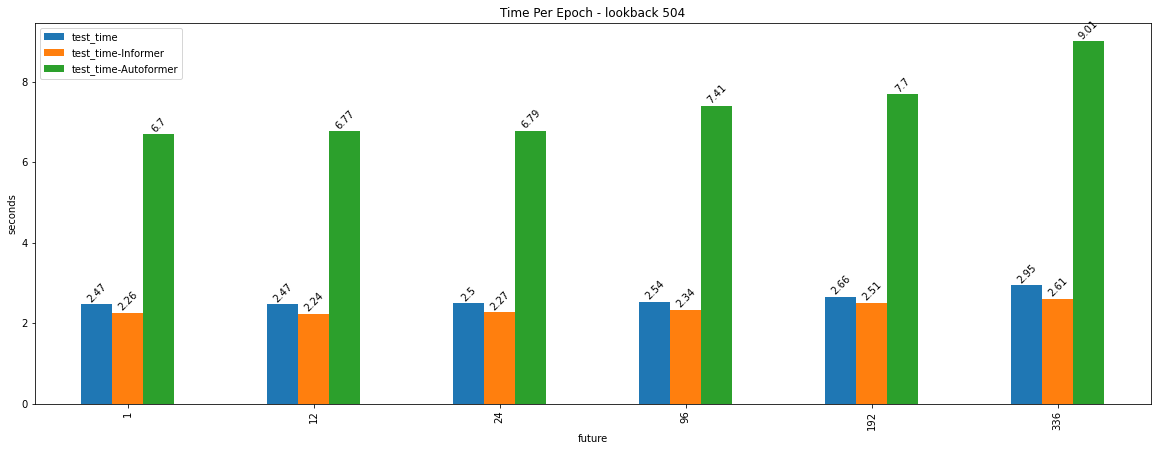

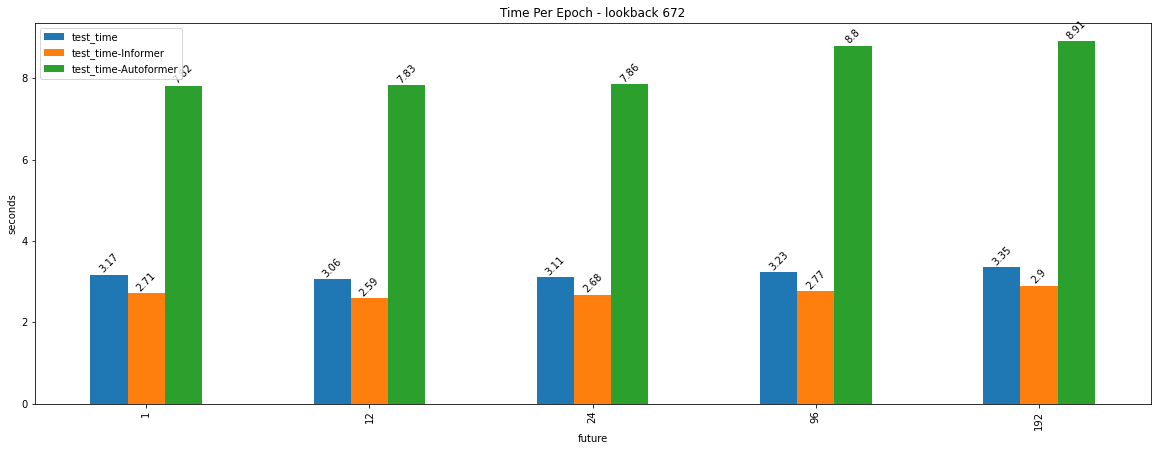

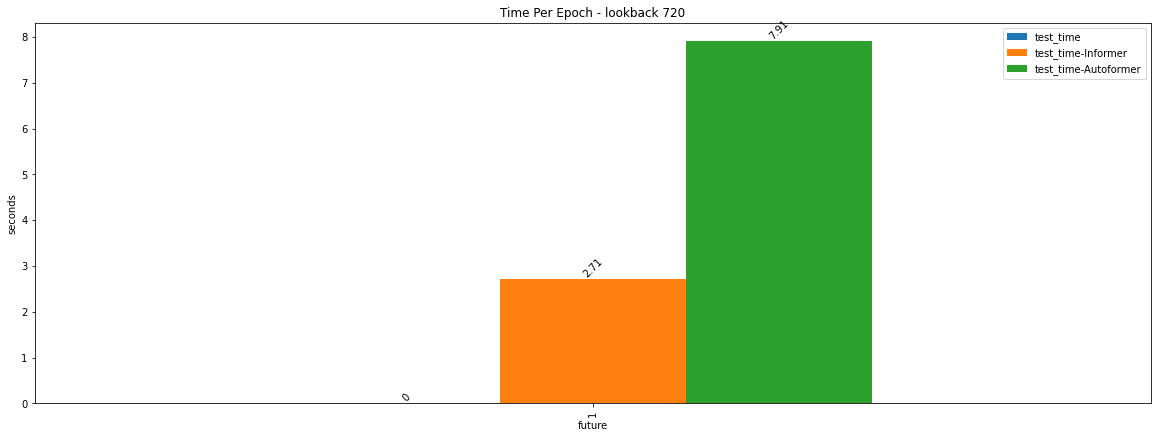

In [21]:
# lookback in [6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672,720]
# lookback = 504
for lookback in [6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672,720]:
#     columns = ['time_per_epoch','time_per_epoch-Informer','time_per_epoch-Autoformer']
    columns = ['test_time','test_time-Informer','test_time-Autoformer']
    # columns = ['test_time','test_time-Autoformer','test_time-Informer']
    time_df = df_org[['lookback', 'future', 'pos', 'val', 'temp',\
                      'time_per_epoch-Autoformer','time_per_epoch-Informer','time_per_epoch',\
                      'test_time-Autoformer','test_time-Informer','test_time',\
                      'train_time-Autoformer','train_time-Informer','train_time',\
                      'epochs-Autoformer','epochs-Informer','epochs']]
    time_df = time_df[time_df['epochs']>2]
    time_inf = time_df[(time_df['lookback'] == lookback) & (time_df['pos'] == 'True')\
            & (time_df['val'] == 'True') & (time_df['temp'] == 'True')]\
            [['lookback', 'future', 'time_per_epoch-Informer','epochs-Informer','test_time-Informer']]
    time_tra = time_df[(time_df['lookback'] == lookback) & (time_df['pos'] == 'True')\
            & (time_df['val'] == 'False') & (time_df['temp'] == 'False')]\
            [['lookback', 'future', 'time_per_epoch','epochs','test_time']]
    time_aut = time_df[(time_df['lookback'] == lookback) & (time_df['pos'] == 'False')\
            & (time_df['val'] == 'True') & (time_df['temp'] == 'True')]\
            [['lookback', 'future', 'time_per_epoch-Autoformer','epochs-Autoformer','test_time-Autoformer']]
    time_formers = time_inf.merge(time_tra, how = "left", on=["lookback", "future"],suffixes=('-Autoformer', '-Informer'))\
                 .merge(time_aut, how = "left", on=["lookback", "future"],suffixes=('_ello', '-Transformer'))
    # time_formers
    time_formers = time_formers.round(2)
#     print(time_formers)
    ax = time_formers.plot.bar(x='future', y=columns, figsize=(20,7))
    ax.set_ylabel('seconds')
    ax.bar_label(ax.containers[0], rotation = 45)
    ax.bar_label(ax.containers[1], rotation = 45)
    ax.bar_label(ax.containers[2], rotation = 45)
    # ax.legend(['Transformer','Informer','Autoformer'])
    ax.set_title('Time Per Epoch - lookback ' + str(lookback))

## SHOW DIFFERENT EMBEDDINGS DATAFRAME ##

In [17]:
pd.set_option('display.expand_frame_repr', True)
def show_best_parameters_for_model(df, model = 'Transformer'):
    df = df.copy(deep=True)
    for lookback in [24, 48, 96, 336, 720]:
#     for lookback in [96]:
        for future in [1, 12, 24, 96, 192, 336, 720]:
            try:
                df_ = df[(df['lookback'] == lookback) & (df['future'] == future)]\
                      [['lookback','future','pos','val','temp','MAE-' + model]].reset_index(drop=True)
                res = df_.iloc[df_['MAE-' + model].idxmin()]
                df_['MAE-' + model] *= 10
                print(df_)
                print(list(res))
                print("=============")
            except Exception as e:
                print('Lookback {} and future {} not found'.format(lookback, future))


show_best_parameters_for_model(df_org, model = 'Transformer')

   lookback  future    pos    val   temp  MAE-Transformer
0        24       1   True   True   True         0.397755
1        24       1   True   True  False         0.300117
2        24       1   True  False   True         0.335413
3        24       1  False   True   True         0.660398
4        24       1  False   True  False         0.829569
5        24       1  False  False   True        22.372336
6        24       1   True  False  False         0.295426
[24, 1, 'True', 'False', 'False', 0.02954257]
   lookback  future    pos    val   temp  MAE-Transformer
0        24      12   True   True   True         0.559929
1        24      12   True   True  False         0.535558
2        24      12   True  False   True         0.593571
3        24      12  False   True   True         4.583408
4        24      12  False   True  False         1.137702
5        24      12  False  False   True        22.475452
6        24      12   True  False  False         0.589795
[24, 12, 'True', 'True', '

## DEFAULT EMBEDDINGS SHOW DATAFRAME ##

In [28]:
def show_by_mse_mae(df_, *args, x_axis = 'future'):
    """."""
    x_axis = x_axis
    df_ = df_.copy(deep=True)
#     df_ = df_[df_['future']!=12]
#     columns = list(args)
    
    if x_axis ==  'lookback':
        frame_by = 'future'
        loopby = [1, 12, 24, 96, 192, 336, 720]
    elif x_axis == 'future':
        frame_by = 'lookback'
        loopby = [24, 48, 72, 96, 120, 144, 168, 336, 720]
#         loopby = [6]
        

    for i in loopby:
        autoformer= df_[(df_[frame_by] == i) & (df_['pos'] == 'False') & (df_['temp'] == 'True')\
                    & (df_['val'] == 'True')][['lookback','future','MSE-Autoformer', 'MAE-Autoformer','MSE-LSTM',\
                                                  'MAE-LSTM']]
        informer = df_[(df_[frame_by] == i) & (df_['pos'] == 'True') & (df_['temp'] == 'True')\
                     & (df_['val'] == 'True')][['lookback','future','MSE-Informer', 'MAE-Informer']]
        transformer = df_[(df_[frame_by] == i) & (df_['pos'] == 'True') & (df_['temp'] == 'False')\
                     & (df_['val'] == 'False')][['lookback','future','MSE-Transformer', 'MAE-Transformer']]
        df_merge = informer.merge(transformer, how = "left", on=["lookback", "future"], suffixes=('_Inf', '_Tra'))\
                   .merge(autoformer, how = "left", on=["lookback", "future"], suffixes=('_ello', '_auto'))
        df_merge *= 10
        df_merge = df_merge.round(3)
        print("lookback ", i)
        df_merge = df_merge.drop(columns=['lookback'])
        df_merge = df_merge.round(5)
        print(df_merge.to_string(index=False))
#         print("=========")

show_by_mse_mae(df_org, x_axis='future')

lookback  24
Empty DataFrame
Columns: [MSE-Informer, MAE-Informer, MSE-Transformer, MAE-Transformer, future, MSE-Autoformer, MAE-Autoformer, MSE-LSTM, MAE-LSTM]
Index: []
lookback  48
 future  MSE-Informer  MAE-Informer  MSE-Transformer  MAE-Transformer  MSE-Autoformer  MAE-Autoformer  MSE-LSTM  MAE-LSTM
     10         0.039         0.457            0.018            0.303           0.039           0.491     0.024     0.368
    120         0.115         0.830            0.050            0.505           0.082           0.665     0.071     0.600
    240         0.118         0.796            0.095            0.698           0.121           0.787     0.343     1.563
    960         0.444         1.588            0.380            1.481           0.336           1.360     1.284     2.926
   1920         0.853         2.381            0.461            1.639           0.565           1.830     7.307     7.851
   3360         2.223         3.803            1.873            3.655           0.93

## BEST EMBEDDINGS SHOW DATAFRAME ##

In [ ]:
pd.set_option('display.expand_frame_repr', False)
def show_by_mse_mae(df_):
    """."""
    df_ = df_.copy(deep=True)
    data = defaultdict(list)
    for lookback in [720]:
        for future in [1, 12, 24, 96, 192, 336, 720]:
            former= df_[(df_['lookback'] == lookback) & (df_['future'] == future)]\
                        [['lookback','future','pos','val','temp','MSE-Autoformer', 'MAE-Autoformer',\
                          'MSE-Informer', 'MAE-Informer',\
                          'MSE-Transformer','MAE-Transformer']]
            data['lookback'].append(lookback)
            data['future'].append(future)
            data['MSE-Info'].append(former['MSE-Informer'].min())
            data['MAE-Info'].append(former['MAE-Informer'].min())
            data['MSE-Trans'].append(former['MSE-Transformer'].min())
            data['MAE-Trans'].append(former['MAE-Transformer'].min())
            data['MSE-Auto'].append(former['MSE-Autoformer'].min())
            data['MAE-Auto'].append(former['MAE-Autoformer'].min())
            print(former)
            print("------")
    return pd.DataFrame.from_dict(data)
return_df = show_by_mse_mae(df_org)
# return_df *= 10
# print(return_df.to_string(index=False))

## SHOW EMBEDDING COMBINATIONS ##

In [ ]:
df_org.head()

In [ ]:
columns

In [ ]:
def show_embeddings_comb(df_, columns, lookback_list):
    df_ = df_.copy(deep=True)
    loopby = [24, 48, 72, 96, 336, 720]

    for lookback in lookback_list:
        print(" "*40 + "============= LOOKBACK {} ==============".format(lookback))
        for pos in ["True", "False"]:
            for val in ["True", "False"]:
                for temp in ["True", "False"]:
                    if pos == "False" and val == "False" and temp == "False":
                        continue
                        
                    ax = df_[(df_['lookback'] == lookback) & (df_['pos'] == pos) & (df_['temp'] == temp)\
                             & (df_['val'] == val)]\
                         .plot.bar(x='future', y=['MAE-Transformer', 'MAE-Informer'], figsize=(15,5))
                    
#                     for y in range(0, len(columns)):
#                         ax.bar_label(ax.containers[y], rotation = 90)
                    
                    if pos == "False" and val == "True" and temp == "True":
                        ax.set_title("pos " + pos + ", Val " + val + ", Temp " + temp + " ==> Default embeddings for AutoFormer")
                    elif pos == "True" and val == "True" and temp == "True":
                        ax.set_title("pos " + pos + ", Val " + val + ", Temp " + temp + " ==> Default embeddings for InFormer")
                    else:
                        ax.set_title("pos " + pos + ", Val " + val + ", Temp " + temp) 
                    plt.show()
# show_embeddings_comb(df_org, columns, [96])

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def show_by_default_embeddings(df_, *args, x_axis = 'future', metric = 'mae'):
    """."""
    x_axis = x_axis
    df_ = df_.copy(deep=True)
    columns = list(args)
    
    if x_axis ==  'lookback':
        frame_by = 'future'
        loopby = [1, 12, 24, 96, 192, 336, 720]
    elif x_axis == 'future':
        frame_by = 'lookback'
        loopby = [6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672,720]
#         loopby = [6]
        

    for i in loopby:
        autoformer= df_[(df_org[frame_by] == i) & (df_['pos'] == 'False') & (df_['temp'] == 'True')\
                    & (df_['val'] == 'True')][['lookback','future',columns[2],columns[3]]]
        informer = df_[(df_org[frame_by] == i) & (df_['pos'] == 'True') & (df_['temp'] == 'True')\
                     & (df_['val'] == 'True')][['lookback','future',columns[1]]]
        transformer = df_[(df_[frame_by] == i) & (df_['pos'] == 'True') & (df_['temp'] == 'False')\
                     & (df_['val'] == 'False')][['lookback','future',columns[0]]]
        df_merge = informer.merge(transformer, how = "left", on=["lookback", "future"], suffixes=('_Inf', '_Tra'))\
                   .merge(autoformer, how = "left", on=["lookback", "future"], suffixes=('_ello', '_auto'))
        df_merge[columns] *= 10
        df_merge = df_merge.round(3)
#         print(df_merge)
#         print("=========")
        ax = df_merge.plot.bar(x=x_axis, y=columns, figsize=(20,7))
#         for y in range(0, len(columns)):
#             ax.bar_label(ax.containers[y], rotation = 60)
        ax.set_title(frame_by.upper() + " "+ str(i))
        ax.set_ylabel(metric.upper())

        

def show(df_, *args, x_axis = 'lookback', pos='True', val='False', temp='False'):
    """."""
    x_axis = x_axis
    df_ = df_.copy(deep=True)
    columns = list(args) 
#     df_[columns] *= 100
    df_ = df_.round(2)
    
    if x_axis ==  'lookback':
        frame_by = 'future'
        loopby = [1, 12, 24, 96, 192, 336, 720]
    elif x_axis == 'future':
        frame_by = 'lookback'
        loopby = [6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672,720]

    for i in loopby:
        ax = df_[(df_[frame_by] == i) & (df_['pos'] == pos) & (df_['temp'] == temp) 
               & (df_['val'] == val)]\
              .plot.bar(x=x_axis, y=columns, figsize=(15,5))
        for y in range(0, len(columns)):
            ax.bar_label(ax.containers[y], rotation = 60)
        ax.set_title(frame_by.upper() + " "+ str(i))

        
def show_embeddings_comb(df_, columns, lookback_list):
    df_ = df_.copy(deep=True)
#     df_[columns] *= 100
#     df_ = df_.round(2)
    

    for lookback in lookback_list:
        print(" "*40 + "============= LOOKBACK {} ==============".format(lookback))
        for pos in ["True", "False"]:
            for val in ["True", "False"]:
                for temp in ["True", "False"]:
                    if pos == "False" and val == "False" and temp == "False":
                        continue
                        
                    ax = df_[(df_['lookback'] == lookback) & \
                             (df_['pos'] == pos) & (df_['temp'] == temp) & (df_['val'] == val)]\
                         .plot.bar(x='future', y=columns, figsize=(15,5))
                    
                    for y in range(0, len(columns)):
                        ax.bar_label(ax.containers[y], rotation = 90)
                    
                    if pos == "False" and val == "True" and temp == "True":
                        ax.set_title("pos " + pos + ", Val " + val + ", Temp " + temp + " ==> Default embeddings for AutoFormer")
                    elif pos == "True" and val == "True" and temp == "True":
                        ax.set_title("pos " + pos + ", Val " + val + ", Temp " + temp + " ==> Default embeddings for InFormer")
                    else:
                        ax.set_title("pos " + pos + ", Val " + val + ", Temp " + temp) 
                    plt.show()



In [ ]:
pos, val, temp = 'True', 'False', 'True'
metric = 'MAE'
columns = list(map(lambda x: metric + x, ['-Transformer','-Informer', '-Autoformer', '-LSTM']))
show_by_default_embeddings(df_org, *columns, x_axis='future', metric=metric)
# show(df_org, *columns, x_axis='future', pos = pos, val = val, temp = temp) 
# for lookback in [6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672,720]:
# show_embeddings_comb(df_org, columns, [96, 120])

In [ ]:
# df_org[(df_org['mae_LSTM'] < df_org['mae_Tra']) \
#        & (df_org['mae_LSTM'] < df_org['mae_Auto']) \
#        & (df_org['mae_LSTM'] < df_org['mae_Inf'])].\
#         sort_values(['lookback','future'])\
#      [['lookback', 'future', 'pos', 'val', 'temp','mae_Tra','mae_Auto','mae_Inf','mae_LSTM']]